In [197]:
import time
from typing import List, Dict

import scipy.integrate
import autograd.numpy as np

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

The first step was to model our Neural Network (NN), which gives the model $f(z(t), t, \theta)$ to how the hidden state changes. In the usual case of an usual, discrete NN, that change corresponds to the following update:

$$ \vec{z}_{t+1} = \vec{z}_t + f(\vec{z}(t), t, \theta)$$

However, using our ODE formulation, the dynamics of the hidden state becomes:

$$ \frac{d\vec{z}(t)}{dt} = f(\vec{z}(t), t, \theta)$$

In [208]:
#1d network to model
# i.e. we are defining dz(t)/dt = f(z(t), t, theta), f given in the nn below.

class SampleODE(nn.Module):
  def __init__(self):
      super(SampleODE, self).__init__()
      self.f = nn.Sequential(
          nn.Linear(1, 1)
      )

  def forward(self, t, z):
    return self.f(z)

The second step was to solve the ODE. Here, a simple implemetation of the Euler method for integration was used to solve the differential equation in the form of $ \frac{d\vec{z}(t)}{dt} = f(\vec{z}(t), t, \theta)$. The Euler method can be written as:
$$\vec{z}_t = \vec{z}_{t-1} + h * f(\vec{z}(t), t, \theta)$$

In [140]:
def grad_f(z, t, p, a, module):
  '''
  Calculates the gradient of the function f with respect to z, t and p (parameters theta).

  ---
  Inputs:
    z: np.array
      Hidden state
    t: float
      Time
    p: ##type##
      Parameters, theta
    a: ##type##
      Adjoint, a
    module: function
      Function f
  ---
  Outputs:
    adfdz: ##type##
      Derivative of f wrt z
    adfdt: ##type##
      Derivative of f wrt t
    adfdp: ##type##
      Derivative of f wrt theta
    f: ##type##
      Function f evaluated at given z and t
  '''
  with torch.set_grad_enabled(True):
    # ensure that we can find gradients using autograd
    z.requires_grad_(True)
    t.requires_grad_(True)
    p.requires_grad_(True)

    # calculate output f; inputs are z, t
    f = module(t, z)
    # p = module.parameters() # in case we need the parameters after function calculation ?
    # torch autograd grad with grad_outputs computes jacobian product
    adfdz = torch.autograd.grad(f, z, grad_outputs=(a))
    adfdt = torch.autograd.grad(f, t, grad_outputs=(a), allow_unused=True)
    adfdp = torch.autograd.grad(f, p, grad_outputs=(a), allow_unused=True)

  return adfdz, adfdt, adfdp, f

  def grad_f_z(z, t, a, module):
    with torch.set_grad_enabled(True):
    # ensure that we can find gradients using autograd
      z.requires_grad_(True)
      f = module(t, z)
      adfdz = torch.autograd.grad(f, z, grad_outputs=(a), allow_unused=True)

    return adfdz

  def grad_f_t(z, t, a, module):
    with torch.set_grad_enabled(True):
    # ensure that we can find gradients using autograd
      t.requires_grad_(True)
      f = module(t, z)
      adfdt = torch.autograd.grad(f, t, grad_outputs=(a), allow_unused=True)

    return adfdt

  def grad_f_p(z, t, p, a, module):
    with torch.set_grad_enabled(True):
    # ensure that we can find gradients using autograd
      p.requires_grad_(True)
      f = module(t, z)
      adfdp = torch.autograd.grad(f, p, grad_outputs=(a), allow_unused=True)

    return adfdp



In [141]:
# solve the ODE:
# backwards pass, this should take the AUGMENTED Z, and have a function f to solve for such.
# forwards pass, take the normal dz(t)/dt = f(z(t), t, theta), find z values.

def ode_solve(z0, t0, t1, f):
  h = .05 # step size
  t = np.linspace(t0, t1, int((abs(t1 - t0))/h))
  z = z0
  for t in range(len(t)):
    z = z + h * f(t, z)
  return z

def adjoint_solve(atf, t0, t1, grad_f):
  # solve the ode backwards
  h = 0.05
  steps = int(abs(t1 - t0) / h)
  t = np.linspace(t0, t1, steps + 1)
  z = atf
  for i in range(1, len(t)):
    time = t[i]
    z = z + h * grad_f
  return z

Next, we defined the dynamics of the augmented state.

A few functions are utilized to describe how the augmented state evolves over time, starting with `grad_f`, the gradient of the function f (parameterized by the NN described previously) with respect to z, t and $\theta$.


The next function, `aug_dynamics`, is used to calculate how the augmented state $\vec{s}(t) = [\vec{z}(t), \vec{a}(t), \frac{\partial L}{\partial\theta}]$ evolves over time. In other words, it returns $\frac{d\vec{s}}{}d$

In [142]:
def aug_dynamics(s, t, theta):
  '''
  Defines dynamics of augmented state.
  ---
  Inputs:
    s: np.array
      Augmented state s (z, a, delL/deltheta) at time t

    t: float
      Time

    theta: np.array
      Dynamic parameters

  ---

  Returns:
    delz_delt: np.array
      Time derivative of state, z

    dela_delt: ##[type]##
      Time derivative of adjoint, a

    deldelL_deltheta_delt: ##[type]##
      Time derivative of loss gradient wrt dynamic parameters, delL_deltheta

  '''
  ### Time derivative of z
  # z is the first component of the augmented state at time t
  z = s[1] # maybe s[1,:]?

  # Compute time derivative of z
  delz_delt = f(z, t, theta)


  ### Time derivative of adjoint
  # Calculate derivative of f wrt z
  delf_delz = ##expression##

  # Vector-jacobian product
  dela_delt = -a.T@delf_delz

  ### Time derivative of loss gradient
  # Calculate derivative of f wrt theta
  delf_deltheta = ##expression##

  # Vector-jacobian product
  deldelL_deltheta_delt = -a.T@delf_deltheta


  return (delz_delt, dela_delt, deldelL_deltheta_delt)

SyntaxError: invalid syntax (<ipython-input-142-6dc64f9dcb28>, line 38)

In [201]:
# we have to create a custom forward and backwards pass
# use torch.autograd.Function for this purpose

class ODEForwardBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, p, func):
      '''
      Finds the z values by solving the ODE
      ---
      Inputs:
        z0: initial state
        t: time vector
        p: parameters
        func: f(z(t), t, theta)
      ---
      Returns:
        z: filled z matrix
      '''
      # because we have our own backwards method, we do not need to track any gradients:
      # for now lets assume z is a vector, no batch
      with torch.no_grad():
        t_len = t.size(0)
        z = torch.zeros(t_len, z0.size(0)).to(z0.device)
        z[0] = z0
        for i in range(t_len - 1):
          # func is a nn.Module. it should apply forward when calling func(--)
          res = ode_solve(z0, t[i], t[i+1], func)
          z[i] = res

      # save the function and t, z, p for backwards pass
      ctx.func = func

      # flatten p


      ctx.save_for_backward(z.clone(), t, p)

      return z

    @staticmethod
    # pytorch AUTOMATICALLY gives us the loss gradient over the entire function.
    # therefore, from that gradient, we must return dldz0, dldt, and dldp
    # this is outlined in the appendix
    def backward(ctx, loss_grad):
      '''
      Finds our gradients wrt our inputs in forward pass
      ---
      Inputs:
        loss_grad: total loss gradient over z
      ---
      Returns:
        grad_z0: Loss gradient wrt z0
        grad_t: loss gradient wrt t
        grad_p: loss gradient wrt parameters
      '''

      #adjoint is dldz
      a = loss_grad

      # how can we get the gradients wrt our inputs?
      # dAaug/dt = -[a∂f/∂z, a∂f/∂θ, a∂f/∂t], integrate both sides

      # get our saved tensors
      func = ctx.func
      z, t, p = ctx.saved_tensors
      adfdz, adfdt, adfdp, out = grad_f(z, t, p, a, func)

      if adfdz[0] is None:
        adfdz = torch.zeros(z.size())
      if adfdt[0] is None:
        adfdt = torch.zeros(t.size())
      if adfdp[0] is None:
        adfdp = torch.zeros(p.size())

      # we can now solve for our gradients by using augmented dynamics
      # can we do it one by one too?
      for i in range(len(t) - 1, 1, -1):
        grad_z0 = adjoint_solve(a, t[i], t[i-1], -adfdz[-1])
        grad_t = adjoint_solve(t, t[i], t[i-1], -adfdt[-1])
        grad_p = adjoint_solve(p, t[i], t[i-1], -adfdp[-1])

      return grad_z0, grad_t, grad_p, None

In [202]:
class NeuralODE(nn.Module):
    def __init__(self, module):
        super(NeuralODE, self).__init__()
        # our func should be a seperate nn.Module, with a forward func
        self.module = module

    def forward(self, z0, t):
        p = self.module.parameters()

        flat_p = []
        for params in p:
          flat_p.append(params.flatten())
        flat_p = torch.cat(flat_p)

        t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)
        z = ODEForwardBackward.apply(z0, t_tensor, flat_p, self.module)
        return z[-2].view(-1, 1)

In [206]:
# model evaluation
ODE = SampleODE()
model = NeuralODE(ODE)

# very simple problem
x = np.linspace(-4*np.pi, 4*np.pi, 300)
y = np.cos(x)

x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# training
t = np.linspace(1, 10, num=10)
t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)

model.train()
epochs = 10
# for now, do batch size of 1, for simpler adjustments in ODE
for epoch in range(epochs):
  total_loss = 0
  for x_1, y_1 in dataloader:
    x_1 = torch.autograd.Variable(x_1, requires_grad=True)
    y_1 = torch.autograd.Variable(y_1, requires_grad=True)

    optimizer.zero_grad()
    y_pred = model(x_1, t_tensor)
    loss = criterion(y_pred, y_1)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  average_loss = total_loss / len(x)
  print ("Epoch:", epoch, "Average Loss:", average_loss)


<ipython-input-202-8685be1e314b>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)


Epoch: 0 Average Loss: 53.54085403815921
Epoch: 1 Average Loss: 53.49164991810375
Epoch: 2 Average Loss: 53.491649918898474
Epoch: 3 Average Loss: 53.491649918898474
Epoch: 4 Average Loss: 53.491649918898474
Epoch: 5 Average Loss: 53.491649918898474
Epoch: 6 Average Loss: 53.491649918898474
Epoch: 7 Average Loss: 53.491649918898474
Epoch: 8 Average Loss: 53.491649918898474
Epoch: 9 Average Loss: 53.491649918898474


<ipython-input-202-8685be1e314b>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)


[0.0, 0.12822827696800232, 0.25645655393600464, 0.38468480110168457, 0.5129131078720093, 0.6411413550376892, 0.7693696022033691, 0.8975979089736938, 1.0258262157440186, 1.1540544033050537, 1.2822827100753784, 1.4105110168457031, 1.5387392044067383, 1.666967511177063, 1.7951958179473877, 1.9234241247177124, 2.051652431488037, 2.1798806190490723, 2.3081088066101074, 2.4363372325897217, 2.564565420150757, 2.692793607711792, 2.8210220336914062, 2.9492502212524414, 3.0774784088134766, 3.205706834793091, 3.333935022354126, 3.4621634483337402, 3.5903916358947754, 3.7186198234558105, 3.846848249435425, 3.97507643699646, 4.103304862976074, 4.231533050537109, 4.3597612380981445, 4.48798942565918, 4.616217613220215, 4.744446277618408, 4.872674465179443, 5.0009026527404785, 5.129130840301514, 5.257359027862549, 5.385587215423584, 5.513815879821777, 5.6420440673828125, 5.770272254943848, 5.898500442504883, 6.026728630065918, 6.154956817626953, 6.2831854820251465]


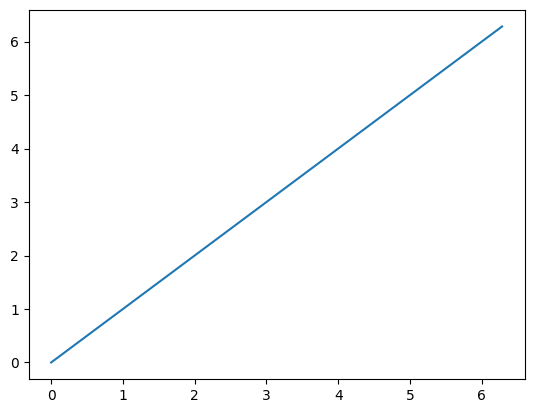

In [207]:
x_test = np.linspace(0*np.pi, 2*np.pi, 50)
y_test = np.cos(x_test)

testset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).view(-1, 1), torch.tensor(y_test, dtype=torch.float32).view(-1, 1))
testloader = DataLoader(testset, batch_size=1)


model.eval()

out = []
for x_1, y_1 in testloader:
  x_1 = torch.autograd.Variable(x_1, requires_grad=True)
  y_1 = torch.autograd.Variable(y_1, requires_grad=True)

  y_pred = model(x_1, t_tensor).item()

  out.append(y_pred)

print(out)

plt.plot(x_test, out)
plt.show()

